Some examples with generating random variables. Let's start with inverse transform method.

<function matplotlib.pyplot.show(close=None, block=None)>

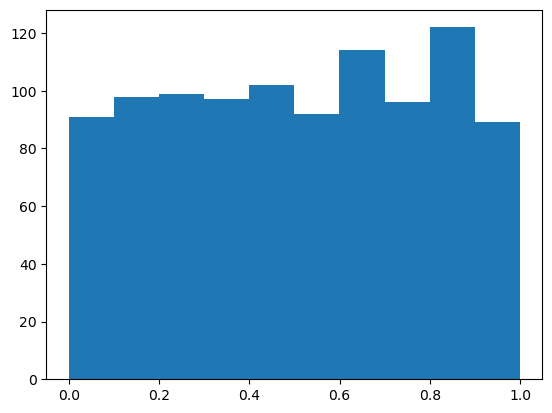

In [1]:
import numpy as np 
import scipy
import matplotlib.pyplot as plt


# generate some samples from uniform distribution
n = 1000

u = np.random.uniform(0, 1, size = n)
u

plt.hist(u)
plt.show

We want to sample from F_X(x) =P(X < x). Inverse method: F_X^(-1)(u) = X, where u ~ U(0, 1). Inverse for exponential: F^(-1)(x) = -lambda*log(1 - x) 

In [2]:
# now we need an inverse of the CDF we want to sample from, let's take exponential. For that, we know an inverse:
def F_exp_inverse(lam, x):
    return -lam*np.log(1 - x)

# define a random sampler for sampling from exponential distribution with mean lam
def get_random_sample(n, lam):
    u = np.random.uniform(0, 1, size = n) 
    # generate exponential
    x_exp = F_exp_inverse(lam, u)
    return x_exp


Now let's generate an exponential sample and compare it to the true distribution

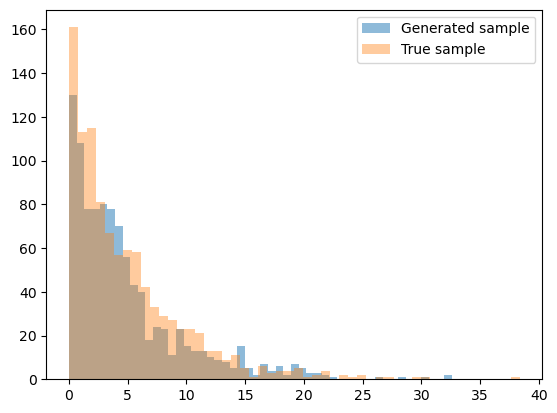

In [3]:
# generated
exp_sample = get_random_sample(n, 5)
# true
exp_true = np.random.exponential(5, size = n)

plt.hist(exp_sample, label = 'Generated sample',  alpha=0.5, bins = 50)
plt.hist(exp_true, label = 'True sample',  alpha=0.4, bins = 50)
plt.legend()
plt.show()

Now let's increase the sample size. The result becomes more exact!

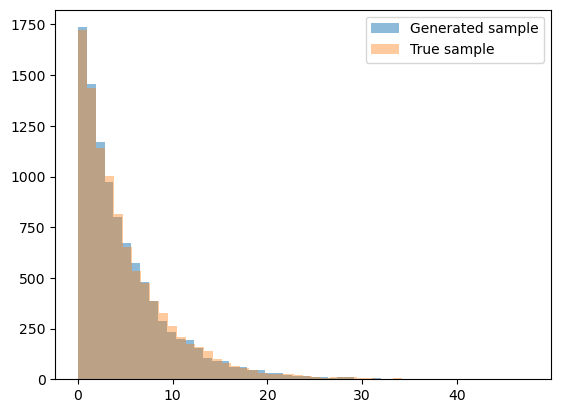

In [4]:
# Repeat with larger n
plt.hist(get_random_sample(10000, 5), label = 'Generated sample',  alpha=0.5, bins = 50)
plt.hist(np.random.exponential(5, size = 10000), label = 'True sample',  alpha=0.4, bins = 50)
plt.legend()
plt.show()


Generate samples from N(10, 5) using Box-Muller method

In [5]:
# program Box-Muller 
def generate_normal(n, mu, sigma):
    
    z_norm = []
    
    # generate from uniform distribution
    u = np.random.uniform(0, 1, size = n+1)  
    
    for i in range(0, n, 2):
           
        # do the transform
        z = [np.sqrt(-2*np.log(u[i]))*np.cos(2*np.pi*u[i+1]), 
             np.sqrt(-2*np.log(u[i]))*np.sin(2*np.pi*u[i+1])]
        
        # don't forget to scale them as required
        z_norm.append(z[0]*sigma+mu)
        z_norm.append(z[1]*sigma+mu)
        
    return z_norm


# since we obtain standard normal distribution, scale the obtained values into whatever we need
mu = 10
sigma = 5
n = 1000

norm_values = generate_normal(n, mu, sigma)


# actual values 
norm_true = np.random.normal(mu, sigma, size= n)



In [6]:
len(norm_values)

1000

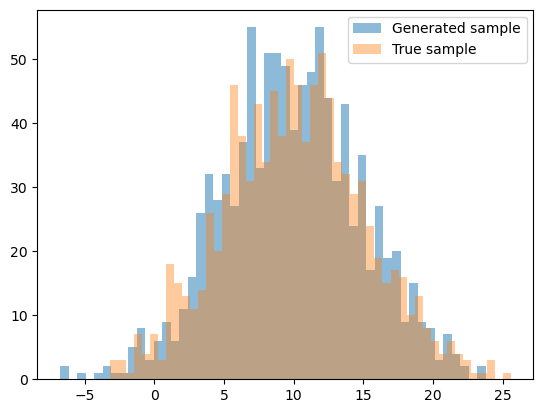

In [7]:
# histogram 

plt.hist(norm_values, label = 'Generated sample',  alpha=0.5, bins = 50)
plt.hist(norm_true, label = 'True sample',  alpha=0.4, bins = 50)
plt.legend()
plt.show()



Generate from standard normal distribution using inverse transform method: scipy



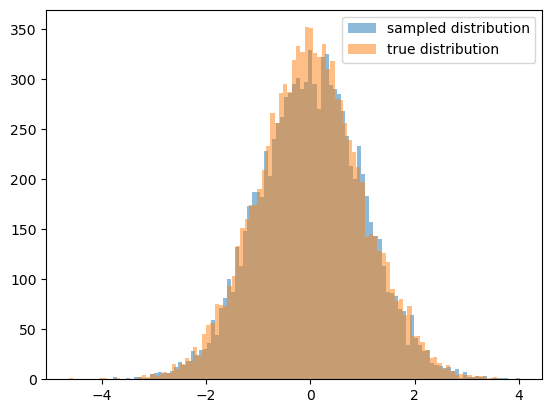

In [8]:
from scipy import stats

n = 10000
# generate uniform
u = np.random.uniform(0, 1, size = n)

# inverse transform of normal: inverse of cdf
z = stats.norm.ppf(u, loc=0, scale=1)

z_true = np.random.normal(0, 1, size = n)

plt.hist(z, bins = 100, label = 'sampled distribution', alpha = 0.5)
plt.hist(z_true, bins = 100, label = 'true distribution', alpha = 0.5)
plt.legend()
plt.show()

Accept-Reject sampling 

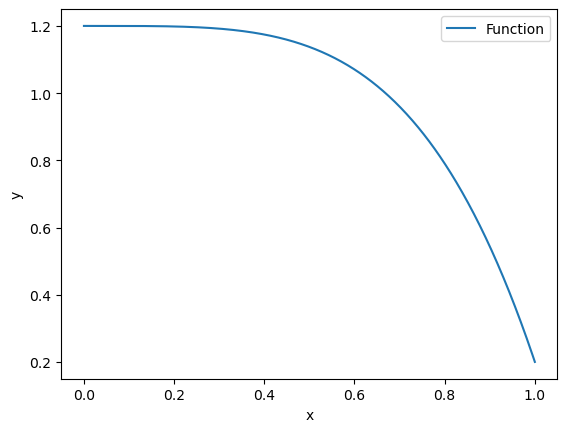

In [9]:
def f(x):
    return 1.2 - x**4

xs = np.linspace(0, 1, 1000)
ys = f(xs)

plt.plot(xs, ys, label="Function") 
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
#plt.fill_between(xs, ys, 0, alpha=0.2)
#plt.xlim(0, 1), plt.ylim(0, 1.25), ;

Accept-reject method EXAMPLE. target: Normal distribution, sample from: exponential.
 Note: we can generate Z = N(0, 1) and then simply scale it as needed by doing X = Z*sigma + mu, then X ~ N(mu, sigma). Moreover, since we sample from exponential distribution Y ~ exp(1) and our target distribution is symmetric, we can put Y = |Z| and then set Z = |Z| w.p. 1/2 and Z = -|Z| w.p. 1/2. 

Note also that:
f(x) = (2/sqrt(2*pi))*e^(-x^2/2), and 
g(x) = e^-x
Hence x_max maximizing the ratio h(x) = f(x)/g(x) is x_max = 1, and  c = h(x_max) = sqrt(2e/pi). (we will use scipy to find it though)

In [10]:
from sympy import *
import numpy as np
from scipy.optimize import minimize


##3 define target density (standard normal)
def f(x):
    return (2/sqrt(2*pi))*np.exp(-x**2/2)

### define sampling density (exponential with unit mean)
def g(x):
    return(np.exp(-x))

# define the ratio f(x)/g(x). Note! define -h(x), since scipy can only minimize 
h_x = lambda x: -(f(x)/g(x))

# define the bounds for x
bnds = [(0.0, 2.0)]

x_max = minimize(h_x, 0.0, bounds=bnds)

# x_max that maximizes the function 
print(x_max.x)

# c = -h(x_max) (don't forget minus!)
c = -h_x(x_max.x)

print(c)


[1.0000067]
[1.64872127066312*sqrt(2)/sqrt(pi)]


In [11]:

############
def generate_normal(n, mu, sigma):
    
    # here we keep our normal samples
    all_sample_z = []
    
    # here we keep the difference between the ration and U
    all_diff = []    
    ### def limiting constant
    #c = sqrt(2*np.exp(1)/pi)
       
    ## start algorithm
    for i in range(n):
        # repeat this until we have u < r(y)
        while 1:
        # generate from target distribution
            y = np.random.exponential(1, size = 1)[0]
            # compute the ratio
            r_y = f(y)/(c*g(y))
            # generate uniform u ~ U(0, 1)
            u = np.random.uniform(0, 1, size = 1)[0]
            
            if u <= r_y:
                Z = y
                # interesting observation: estimate the difference between Y and the ratio when Y accepted
                y_dif = -np.log(u) - (-np.log(np.float64(r_y[0])))
                all_diff.append(y_dif)
                break
        # generate the sign    
        u_sign = np.random.uniform(0, 1, 1)[0]
        if u_sign > 0.5:
            Z = -Z
        all_sample_z.append(Z*sigma+mu)
    
    return [all_sample_z, all_diff]
        
        

In [12]:
# test our function
n = 10000
z_sampled = generate_normal(n, 10, 5)



In [13]:
z_samples = z_sampled[0]

diff_samples = z_sampled[1]

# check mean - should be 1!
np.mean(diff_samples)

0.9903691639250155

Check: what is the distribution of the difference X = -log(u) - log(r(Y))?

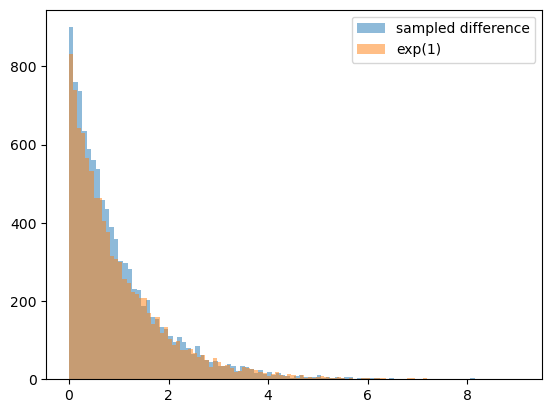

In [14]:
exp_true = np.random.exponential(1, size = len(diff_samples))

plt.hist(diff_samples, bins = 100, alpha  = 0.5, label = 'sampled difference')
plt.hist(exp_true, bins = 100, alpha = 0.5, label = 'exp(1)')
plt.legend()
plt.show()

Now plot the obtained distribution and compare it to the real one

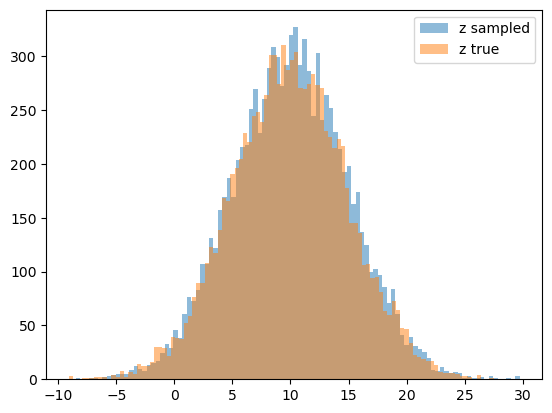

In [15]:
z_true = np.random.normal(10,  5, size = n)

plt.hist(z_samples, label = 'z sampled', alpha = 0.5, bins = 100)
plt.hist(z_true, label = 'z true', alpha = 0.5, bins= 100)
plt.legend()
plt.show()




Markov chains: small example

In [16]:
import numpy as np
import random as rm

# define the state space
states = ["state1","state2","state3"]


# Possible sequences of events
transitionName = [["11","13","12"],["32","33","31"],["21","23","22"]]

# Probabilities matrix (transition matrix)
transitionMatrix = [[0.2,0.6,0.2],[0.1,0.6,0.3],[0.2,0.7,0.1]]

# check if sum to 1
sum(transitionMatrix[0])+sum(transitionMatrix[1])+sum(transitionMatrix[2]) == 3

True

Implement a Markov model 

In [17]:



def generate_my_mc(time = 10):
    
    # we observe the MC for 10 iterations
    
    prob = 1
    
    cur_state = "state1"

    # let's say we start from the 1st state
    states_list = [cur_state]
    
    # now run over all states and account for all possible combinations
    i = 0
    while i != time:
        if cur_state == "state1":
            change = np.random.choice(transitionName[0],replace=True,p=transitionMatrix[0])
            if change == "11":
                prob = prob * 0.2
                states_list.append("state1")
                pass
            elif change == "13":
                prob = prob * 0.6
                cur_state = "state3"
                states_list.append("state3")
            else:
                prob = prob * 0.2
                cur_state = "state2"
                states_list.append("state2")
                
        elif  cur_state== "state3":
                change = np.random.choice(transitionName[1],replace=True,p=transitionMatrix[1])
                if change == "33":
                    prob = prob * 0.5
                    states_list.append("state2")
                    pass
                elif change == "23":
                    prob = prob * 0.2
                    activityToday = "state1"
                    states_list.append("state1")
                else:
                    prob = prob * 0.3
                    activityToday = "state2"
                    states_list.append("state2")
        elif  cur_state== "state2":
                change = np.random.choice(transitionName[2],replace=True,p=transitionMatrix[2])
                if change == "22":
                    prob = prob * 0.1
                    states_list.append("state2")
                    pass
                elif change == "21":
                    prob = prob * 0.2
                    activityToday = "state1"
                    states_list.append("state1")
                else:
                    prob = prob * 0.7
                    activityToday = "state3"
                    states_list.append("state3")
                
        i += 1  
        
    return states_list

Expected number of steps to get to state 2 from state 1

In [18]:
k = 1000

req_number_total = []

for j in range(k):
    states_list = generate_my_mc(10)
    # required number of steps to get to state 2
    n_req = states_list.index("state2")
    
    req_number_total.append(n_req)
    
    
    

In [19]:
np.mean(req_number_total)

1.968